# Extended Data Fig. 4 (panels h-m)
- This experiment tests whether the fish HD neurons can track visual cues in upper/lower visual fields.
- The experiment starts with repeated presentations of flashes, followed by the sequential presentations of the "sun-and-bars", "bottom cue", and "top cue" scenes
- This notebook generates data panels **Extended Data Fig. 4h-m**.
- Note that the results of bootstrap tests can very mildly fluctuate by the random number generator seed, which we did not fix in the reviewed version. The conclusions of all the analysis are robust to this fluctuation. 

In [1]:
# Import packages
from utility import *
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
from scipy.stats import binned_statistic, kstest, uniform
from scipy.signal import convolve2d
import json
import colorcet as cc

C:\Users\ryosuke\miniconda3\envs\hd_pub\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\ryosuke\miniconda3\envs\hd_pub\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\ryosuke\miniconda3\envs\hd_pub\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
# configure matplotlib
config_rcparams()

In [3]:
# parameters
R2_thresh = 0.15  # for sinusoidal fit
flash_thresh = 0.1 # for rejecting flash responsive cells
n_heading_bin = 8 # binning HD cells
n_offset_bin = 16 # binning scene-bump offset
n_bootstrap = 1000 # #bootstrap shuffles

mask_name = 'rhombomere1'

labels = ('sun and bars', 'bottom cue', 'top cue')

In [4]:
# get a list of fish
fish_list = get_fish_list('../data/ed04b', silent=True)
nested_list = nest_fish_list_per_fish(fish_list)

# Analysis
## Data extraction and ROI selection

In [5]:
data = []

# Go through all unique fish
for fish_id, recording_list in enumerate(nested_list):
    
    data.append([])
    
    # Go through all recordings
    for recording in recording_list:
        
        # Load the latest mask
        mask_list = list(recording.glob('mask_'+mask_name+'*'))
        with open(mask_list[-1], 'r') as f:
            mask = json.load(f)
        
        #################
        ### Load data ###
        #################

        # Load behavior and imaging data
        s2p_data, t_i, exp = load_data(recording, cells_only=False)

        # pull out relevant data from dict
        roi_coords = s2p_data['coords'] # ROI coordinates, for masking
        slog = exp['stimulus']['log'] # list of dict, specifying stimulus epochs
        t_s = exp.stimulus_log['t'].to_numpy() # time stamp for stimuli 
        theta = exp.stimulus_log['cl2D_theta'].to_numpy() # scene orientation
        theta_i = downsample_traces(t_s, theta, t_i) # downsample to imaging timestamps
        
        # restrict rois by mask (do this before functional selection to reduce the time-consuming nonlinear curve fitting)
        in_mask = (roi_coords[:, 2] > mask['x0']) * (roi_coords[:, 2] < mask['x1']) * (roi_coords[:, 1] > mask['y0']) * (roi_coords[:, 1] < mask['y1'])
        traces = s2p_data['traces'][in_mask,:len(t_i)]
        roi_coords = roi_coords[in_mask, :]
        n_roi = traces.shape[0]
        
        # normalization & smoothing
        norm_traces = ((traces.T - np.median(traces, axis=1))/np.std(traces, axis=1)).T
        smoothed_traces = convolve2d(norm_traces, np.ones((1,5))/5, mode='same')
        
        #####################
        ### ROI selection ###
        #####################
        
        # Flash
        flash_duration = slog[1]['duration']*2
        flash_t_start = [epoch['t_start'] for epoch in slog[1:-2:2]] # first epoch is wait, last two epochs are sun-and-bars and stonehenge. 
        flash_corr = calc_snip_correlation(norm_traces, t_i, flash_t_start, flash_duration)
        
        # Sinusoidal regression (use the entirity of the sun and bars epoch)
        # epochs are ordered as flashes, sun and bars, cue card below, cue card above
        is_valid_theta = (np.isnan(theta_i)==False) * (t_i < slog[-2]['t_start'])
        fit_param, _, R2 = fit_transform_sinusoid(smoothed_traces[:, is_valid_theta], theta_i[is_valid_theta])
        
        # do the selection
        good_fit = (R2 > R2_thresh) * (flash_corr < flash_thresh)
        print(recording, 'Found', np.sum(good_fit), 'good ROIs out of', n_roi )
        
        ### Save everything in a dictionary ###
        D = {'stack': s2p_data['anatomy_stack'][0,:,:],
             'slog': slog,
             't_s': t_s,
             't_b': exp.behavior_log['t'].to_numpy(),
             'fish_theta': exp.stimulus_log['cl2D_fish_theta'].to_numpy(),
             'theta_update_spike': exp.stimulus_log['cl2D_start_theta_update'].to_numpy(),
             'tail_sum': exp.behavior_log['tail_sum'].to_numpy(),
             't_i': t_i,
             'theta_i': theta_i,
             'traces': smoothed_traces[good_fit, :],
             'fit_param': fit_param[good_fit,:],
             'coords': roi_coords[good_fit, :]}
        data[-1].append(D)

..\data\ed04b\20250401_f0_E84_v12_115 Found 47 good ROIs out of 127
..\data\ed04b\20250401_f1_E84_v12_175 Found 24 good ROIs out of 91
..\data\ed04b\20250401_f2_E84_v12_123 Found 4 good ROIs out of 96
..\data\ed04b\20250401_f3_E84_v12_170 Found 11 good ROIs out of 114
..\data\ed04b\20250401_f4_E84_v12_185 Found 27 good ROIs out of 139
..\data\ed04b\20250401_f5_E84_v12_135 Found 9 good ROIs out of 115
..\data\ed04b\20250402_f0_v84_z115 Found 68 good ROIs out of 148
..\data\ed04b\20250402_f1_v84_z147 Found 44 good ROIs out of 125
..\data\ed04b\20250402_f2_v84_z184 Found 57 good ROIs out of 181
..\data\ed04b\20250402_f3_v84_z151 Found 61 good ROIs out of 156
..\data\ed04b\20250402_f4_v84_z79 Found 36 good ROIs out of 117
..\data\ed04b\20250409_f1_elevation_p2 Found 24 good ROIs out of 165
..\data\ed04b\20250409_f3_elevation Found 2 good ROIs out of 88
..\data\ed04b\20250410_f0_elevation Found 46 good ROIs out of 133
..\data\ed04b\20250410_f1_elevation Found 80 good ROIs out of 153
..\data

## Additional preprocessing
- Calculate bump phase
- Reject fish with less than 4 bins

In [6]:
bad_recs = []
for i, fish_data in enumerate(data):
    for j, D in enumerate(fish_data):
        # PVA calculation
        pva_theta, pva_length, binned_traces, _, _ = calc_binned_pva(D['traces'], D['fit_param'][:,1], n_bin=n_heading_bin)
        
        n_empty_bins = np.sum(np.isnan(binned_traces[:,0]))
        
        if n_empty_bins < 5:        
            data[i][j]['pva_theta'] = pva_theta
            data[i][j]['pva_length'] = pva_length
            data[i][j]['binned_traces'] = binned_traces
        else:
            bad_recs.append((i,j))

# pop bad recs from big ones
for i, j in bad_recs[::-1]:
    data[i].pop(j)
data = [fish for fish in data if fish]

## Offset histogram calculation & Bootstrap testing
- will take a couple minutes

In [7]:
offset_bin_edges = np.linspace(-np.pi, np.pi, n_offset_bin+1)
offset_bin_center = (offset_bin_edges[:-1] + offset_bin_edges[1:])/2

for i, fish_data in enumerate(data):
    for j, D in enumerate(fish_data):
        
        # Fit von Mises distribution to the offset between the bump and scene orientation
        # during the bottom / top cue epochs, separately
        bump_scene_offset = angular_diff(D['theta_i'], D['pva_theta'])
        
        is_low  = (D['t_i']>D['slog'][-2]['t_start']) * (D['t_i']<D['slog'][-1]['t_start'])
        is_high = D['t_i']>D['slog'][-1]['t_start']
        
        low_hist  = np.histogram(bump_scene_offset[is_low],  bins=offset_bin_edges, density=True)[0]        
        high_hist = np.histogram(bump_scene_offset[is_high], bins=offset_bin_edges, density=True)[0]
        
        low_fit, _  = curve_fit(von_Mises, offset_bin_center, low_hist,  bounds=([-np.pi,0], [np.pi,np.inf]))
        high_fit, _ = curve_fit(von_Mises, offset_bin_center, high_hist, bounds=([-np.pi,0], [np.pi,np.inf]))
        
        shuffle_kappa = np.zeros((2, n_bootstrap))
        for k, is_epoch in enumerate((is_low, is_high)):
            for b in tqdm(range(n_bootstrap)):
                # shift theta and bump by a random amount, recalculate offset, fit von Mises again
                shuffled_offset = angular_diff(D['theta_i'][is_epoch], np.roll(D['pva_theta'][is_epoch], np.random.randint(np.sum(is_epoch))))
                shuffled_hist = np.histogram(shuffled_offset, bins=offset_bin_edges, density=True)[0]
                shuffled_fit, _ = curve_fit(von_Mises, offset_bin_center, shuffled_hist, bounds=([-np.pi,0], [np.pi,np.inf]))
                shuffle_kappa[k, b] = shuffled_fit[1]
            
        data[i][j]['offset_hist'] = np.vstack((low_hist, high_hist))
        data[i][j]['fit_mu'] = (low_fit[0], high_fit[0])
        data[i][j]['fit_kappa'] = (low_fit[1], high_fit[1])
        data[i][j]['bs_med_kappa'] = np.median(shuffle_kappa, axis=1)
        data[i][j]['bs_95pt_kappa'] = np.percentile(shuffle_kappa, 95, axis=1)
        data[i][j]['p_kappa'] = (np.mean(shuffle_kappa[0, :] > low_fit[1]), np.mean(shuffle_kappa[1, :] > high_fit[1]))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.35it/s]


# Panels
## Extended Data Fig. 4i (individual fish example, with behavioral and neural traces)

In [8]:
# Pick an example fish
fid = 12
rid = 0

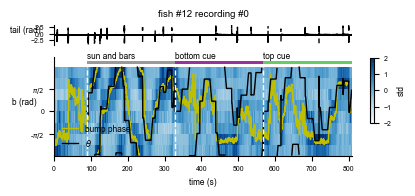

In [9]:
D = data[fid][rid]

# prepare axes
fig, ax = plt.subplots(2, 1, figsize=(4.8, 1.7), height_ratios=(1,5))

## Behavioral time trace
ax[0].plot(D['t_b'], D['tail_sum'], label='tail sum', lw=1, color='black')
ax[0].set_title('fish #{0} recording #{1}'.format(fid,rid))
ax[0].set_ylabel('tail (rad)', rotation=0)
toggle_spines(ax[0],0,0,0,1)

## Neural time trace
# Trace
im = ax[1].imshow(D['binned_traces'][::-1, :], aspect='auto', interpolation='nearest', vmax=2, vmin=-2, extent=(0, max(D['t_i']), -np.pi, np.pi), cmap='Blues')
# Theta and reconstructed theta
ax[1].plot(D['t_i'], wrapped(np.unwrap(D['pva_theta']), offset=np.pi), 'y-', linewidth=1, label='bump phase')
ax[1].plot(D['t_i'], wrapped(D['theta_i'], offset=np.pi), 'k-', linewidth=1, label=r'$\theta$')
ax[1].legend()

# boundaries between the epochs
for i, j in enumerate((10, 9, 1)): # enumerating for coloring (I forgot why we are doing this backward... shouldn't matter)
    this_t = slog[-i-1]['t_start']
    this_d = slog[-i-1]['duration']
    ax[1].plot((this_t,this_t),(-np.pi,np.pi),'w--')
    ax[1].fill_between((this_t, this_t+this_d), (np.pi+0.2, np.pi+0.2), (np.pi+0.4, np.pi+0.4), facecolor=color_getter(j), edgecolor='none')
    ax[1].text(this_t, np.pi+0.6, labels[2-i])

ax[1].set_yticks([-np.pi/2, 0, np.pi/2])
ax[1].set_yticklabels((r'-$\pi/2$', '0', r'$\pi/2$'))
ax[1].set_ylabel('b (rad)', rotation=0)
ax[1].set_xlabel('time (s)')
cb = plt.colorbar(im, ax=ax, shrink=0.5)
cb.set_label('std')

toggle_spines(ax[1],0,1,0,1)
for axx in ax:
    axx.set_xlim(0, max(t_i))
    
plt.savefig('../svg/ed04_i.svg')
plt.show()

## Extended Data Fig. 4j (example fish scene-bump offset histograms with fit per condition)

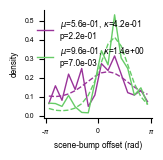

In [10]:
# show histogram with fit
fig, ax = plt.subplots(1, 1, figsize=(1.4,1.4))

for i in range(2):
    ax.plot(offset_bin_center, D['offset_hist'][i], color=color_getter(9+i), label='$\mu$={:0.1e}, $\kappa$={:0.1e}\np={:0.1e}'.format(D['fit_mu'][i], D['fit_kappa'][i], D['p_kappa'][i]))
    ax.plot(offset_bin_center, von_Mises(offset_bin_center, D['fit_mu'][i], D['fit_kappa'][i]), ls='--', color=color_getter(9+i))

ax.set_xticks([-np.pi, 0, np.pi])
ax.set_xticklabels((r'-$\pi$', '0', r'$\pi$'))
ax.set_xlabel('scene-bump offset (rad)')
ax.set_ylabel('density')
ax.legend()
toggle_spines(ax, 0, 1, 0, 1)

plt.savefig('../svg/ed04_j.svg')
plt.show()

## Extended Data Fig. 4k, l (Population $\kappa$ with bootstrap and across conditions)

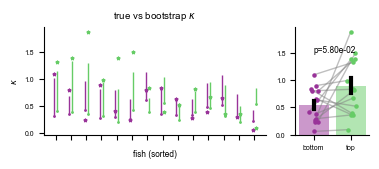

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(4.2,1.4), width_ratios=(3,1))

# Bootstrap result
fit_kappa     = np.asarray([temp[0]['fit_kappa'] for temp in data])
fit_mu        = np.asarray([temp[0]['fit_mu'] for temp in data])
bs_med_kappa  = np.asarray([temp[0]['bs_med_kappa'] for temp in data])
bs_95pt_kappa = np.asarray([temp[0]['bs_95pt_kappa'] for temp in data])
p_kappa       = np.asarray([temp[0]['p_kappa'] for temp in data])

sort_x = np.argsort(np.argsort(-np.mean(fit_kappa, axis=1)))
w = 0.1

for i in range(2):
    ax[0].scatter(sort_x+i*w*2-w, fit_kappa[:, i], s=5, color=color_getter(9+i), marker='*')
    ax[0].errorbar(sort_x+i*w*2-w, bs_med_kappa[:, i], np.vstack((0*bs_med_kappa[:, i], bs_95pt_kappa[:, i]-bs_med_kappa[:, i])),
                   marker='.', color=color_getter(9+i), ls='none', markersize=2)
    
ax[0].set_xticks(range(len(p_kappa)))
ax[0].set_xticklabels([])
ax[0].set_xlabel('fish (sorted)')
ax[0].set_ylabel('$\kappa$')
ax[0].set_title('true vs bootstrap $\kappa$')
toggle_spines(ax[0], 0, 1, 0, 1)

# compare across conditions
p = scatter_bar(fit_kappa.T, ax=ax[1], connect=True, color=color_getter((9,10)), s=5, condnames=('bottom','top'))
ax[1].text(0, 1.5, 'p={:0.2e}'.format(p[0,1]))
toggle_spines(ax[1], 0, 1, 0, 1)

plt.savefig('../svg/ed04_kl.svg')
plt.show()

## Extended Data Fig. 4m (cumulative distribution of bootstrap p-values)

In [16]:
# calculate cdf
p_x = np.linspace(0,1,1000)
bottom_p_cdf = np.asarray([np.mean(p_kappa[:, 0]<x) for x in p_x])
top_p_cdf = np.asarray([np.mean(p_kappa[:, 1]<x) for x in p_x])

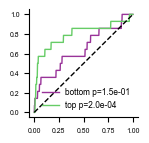

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(1.4, 1.4))
ax.plot(p_x, bottom_p_cdf, color=color_getter(9), label='bottom p={:0.1e}'.format(kstest(p_kappa[:, 0], uniform.cdf)[1]))
ax.plot(p_x, top_p_cdf, color=color_getter(10), label='top p={:0.1e}'.format(kstest(p_kappa[:, 1], uniform.cdf)[1]))
ax.plot(p_x, p_x, 'k--')
ax.legend()
toggle_spines(ax,0,1,0,1)
plt.savefig('../svg/ed04_m.svg')
plt.show()

In [22]:
# report stats
print('bottom p against uniform', kstest(p_kappa[:, 0], uniform.cdf)[1])
print('top p against uniform', kstest(p_kappa[:, 1], uniform.cdf)[1])
print('top p against bottom p', kstest(p_kappa[:, 0], p_kappa[:, 1])[1])

bottom p against uniform 0.1536557647048863
top p against uniform 0.00020478047132386226
top p against bottom p 0.3433204708275377
